This notebook is also available in Google Colab for better sectioning and readibillity
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/12Qy_DurFbCZUadargcHoBgUPX2ROrXC4?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Data Preparation
***

In [3]:
!pip install catboost
!pip install imbalanced-learn

  Using cached graphviz-0.19.1-py3-none-any.whl (46 kB)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling as pp
import seaborn as sns
sns.set()

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from catboost import CatBoostClassifier
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb

%matplotlib inline

The data is from Kaggle competition: [Give Me Some Credit](https://www.kaggle.com/competitions/GiveMeSomeCredit/)

In [4]:
data = pd.read_csv('cs-training.csv')
test = pd.read_csv('cs-test.csv')

In [5]:
data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
data = data.drop(columns = ['Unnamed: 0'])
test = test.drop(columns = ['Unnamed: 0'])

***
Now, let's look at the definition of each column and its data type.

Variable Name : Description **Type**

* SeriousDlqin2yrs : Person experienced 90 days past due delinquency or worse **Y/N**
* RevolvingUtilizationOfUnsecuredLines : Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits **percentage**
* age : Age of borrower in years **integer**
* NumberOfTime30-59DaysPastDueNotWorse : Number of times borrower has been 30-59 days past due but no worse in the last 2 years. **integer**
* DebtRatio : Monthly debt payments, alimony,living costs divided by monthy gross income **percentage**
* MonthlyIncome : Monthly income **real**
* NumberOfOpenCreditLinesAndLoans : Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) **integer**
* NumberOfTimes90DaysLate : Number of times borrower has been 90 days or more past due. **integer**
* NumberRealEstateLoansOrLines : Number of mortgage and real estate loans including home equity lines of credit **integer**
* NumberOfTime60-89DaysPastDueNotWorse : Number of times borrower has been 60-89 days past due but no worse in the last 2 years. **integer**
* NumberOfDependents : Number of dependents in family excluding themselves (spouse, children etc.) **integer**


# Data Preprocessing
***

Let's first look at the dataset general information.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

There are missing values in MonthlyIncome and NumberOfDependents columns.
Let's look at the data distribution first, then we can decide what to do with the missing values.

Dataset in fraud or credit risk is typically imbalanced so we plot SeriousDlqin2yrs count to see if it apply to this dataset aswell. 

0    0.93316
1    0.06684
Name: SeriousDlqin2yrs, dtype: float64

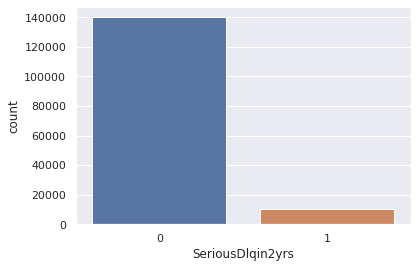

In [9]:
# Plot count in target column and we can see that the dataset is unbalanced
sns.countplot(x='SeriousDlqin2yrs',data=data)
data['SeriousDlqin2yrs'].value_counts(normalize=True)

We can see that the dataset really is unbalanced. We will try to implement the model first, then evaluate whether the model can deal with it or do we need to do something with it.


In [10]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


RevolvingUtilizationOfUnsecuredLines and DebtRatio have some strange distribution. Their quantile are in decimal units but their mean not. Maybe there is somethings going on here?

Before we process the data, we will rename the columns first for simplicity and readibility.

In [11]:
columns_re = {
    'SeriousDlqin2yrs':'target',
    'RevolvingUtilizationOfUnsecuredLines':'revolving util',
    'NumberOfTime30-59DaysPastDueNotWorse':'30-59',
    'DebtRatio':'debt ratio',
    'MonthlyIncome':'income',
    'NumberOfOpenCreditLinesAndLoans':'open loans&credit',
    'NumberOfTimes90DaysLate':'90',
    'NumberRealEstateLoansOrLines':'real estate',
    'NumberOfTime60-89DaysPastDueNotWorse':'60-89',
    'NumberOfDependents':'dependents'
}

data = data.rename(columns=columns_re)
test = test.rename(columns=columns_re)

Then we look at the revolving util and debt ratio that is different from their majority.

In [12]:
data[data['revolving util']>6]

,target,revolving util,age,30-59,debt ratio,income,open loans&credit,90,real estate,60-89,dependents
293,0,2340.000000,45,0,0.339333,8333.0,7,0,2,0,2.0
697,1,2066.000000,58,0,0.271121,6000.0,8,1,1,0,1.0
1991,1,1143.000000,44,2,0.547762,6500.0,13,0,4,0,2.0
2331,0,6324.000000,59,0,0.136673,11318.0,4,0,1,0,1.0
4278,0,1982.000000,33,0,0.144982,8000.0,4,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
148828,1,73.846154,53,2,0.513355,7000.0,5,8,2,0,4.0
149102,0,6109.000000,43,0,0.229902,12500.0,9,0,2,0,0.0
149160,0,22000.000000,38,0,1.080020,3973.0,7,0,2,0,3.0
149245,0,771.000000,52,0,0.832021,8000.0,13,0,3,0,0.0


In [13]:
data[data['debt ratio']>6]

,target,revolving util,age,30-59,debt ratio,income,open loans&credit,90,real estate,60-89,dependents
6,0,0.305682,57,0,5710.0,NaN,8,0,3,0,0.0
8,0,0.116951,27,0,46.0,NaN,2,0,0,0,NaN
14,0,0.019657,76,0,477.0,0.0,6,0,1,0,0.0
16,0,0.061086,78,0,2058.0,NaN,10,0,2,0,0.0
32,0,0.083418,62,0,977.0,NaN,6,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149976,0,0.000627,76,0,60.0,NaN,5,0,0,0,0.0
149977,0,0.236450,29,0,349.0,NaN,3,0,0,0,0.0
149984,0,0.037548,84,0,25.0,NaN,5,0,0,0,0.0
149992,0,0.871976,50,0,4132.0,NaN,11,0,1,0,3.0


We suspect that this could be a result of data entry error that most of the data is in ratio but some is put in as %.

Ex. 0.73 | 73%

So, we will try to divide most of the data that seem impossible, which is more than 5 (or 500%).

In [14]:
data_div = data.copy(deep=True)

In [15]:
data_div['debt ratio'] = data_div['debt ratio'].apply(lambda x: x/100 if x>=5 else x)
data_div['revolving util'] = data_div['revolving util'].apply(lambda x: x/100 if x>=5 else x)

In [16]:
data_div.describe()

,target,revolving util,age,30-59,debt ratio,income,open loans&credit,90,real estate,60-89,dependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,0.378969,52.295207,0.421033,3.821107,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,2.516469,14.771866,4.192781,20.331594,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.166601,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154074,52.000000,0.000000,0.349808,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.558679,63.000000,0.000000,0.709310,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,507.080000,109.000000,98.000000,3296.640000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Now that the distribution is much more reasonable, we will fill the missing values.

We will try to impute both the income and dependents according to the average of the people in the same age.

In [17]:
data_div[['income','dependents']] = data_div[['income','dependents','age']].groupby('age').transform(lambda x: x.fillna(x.mean()))
data_div.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   target             150000 non-null  int64  
 1   revolving util     150000 non-null  float64
 2   age                150000 non-null  int64  
 3   30-59              150000 non-null  int64  
 4   debt ratio         150000 non-null  float64
 5   income             149996 non-null  float64
 6   open loans&credit  150000 non-null  int64  
 7   90                 150000 non-null  int64  
 8   real estate        150000 non-null  int64  
 9   60-89              150000 non-null  int64  
 10  dependents         149997 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [18]:
test[['income','dependents']] = test[['income','dependents','age']].groupby('age').transform(lambda x: x.fillna(x.mean()))
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   target             0 non-null       float64
 1   revolving util     101503 non-null  float64
 2   age                101503 non-null  int64  
 3   30-59              101503 non-null  int64  
 4   debt ratio         101503 non-null  float64
 5   income             101499 non-null  float64
 6   open loans&credit  101503 non-null  int64  
 7   90                 101503 non-null  int64  
 8   real estate        101503 non-null  int64  
 9   60-89              101503 non-null  int64  
 10  dependents         101503 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 8.5 MB


We fill in most of the missing values. Let's look at this 7 missing values.

In [19]:
data_div[data_div.isna().any(axis=1)]

,target,revolving util,age,30-59,debt ratio,income,open loans&credit,90,real estate,60-89,dependents
40007,0,0.064748,107,0,9.39,NaN,9,0,1,0,0.0
56761,0,0.003469,105,0,2.00,NaN,4,0,0,0,NaN
105790,0,0.109307,109,0,21.41,NaN,17,0,1,0,NaN
138291,0,0.246529,109,0,3.18,NaN,3,0,0,0,NaN


In [20]:
test.drop('target',axis=1)[test.drop('target',axis=1).isna().any(axis=1)]

,revolving util,age,30-59,debt ratio,income,open loans&credit,90,real estate,60-89,dependents
16913,0.000000,98,0,0.0,NaN,3,0,0,0,0.0
17669,0.052467,98,0,50.0,NaN,2,0,0,0,0.0
35076,0.729798,104,2,1746.0,NaN,12,0,2,1,0.0
80071,0.022819,98,0,8.0,NaN,1,0,0,0,0.0


There are 7 missing values from 4 customers who are over 100 years old.
So, we will fill it with average from people who are over 100 years old.

In [21]:
data_div = data_div.fillna(data_div[data_div['age']>100].mean())
data_div.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   target             150000 non-null  int64  
 1   revolving util     150000 non-null  float64
 2   age                150000 non-null  int64  
 3   30-59              150000 non-null  int64  
 4   debt ratio         150000 non-null  float64
 5   income             150000 non-null  float64
 6   open loans&credit  150000 non-null  int64  
 7   90                 150000 non-null  int64  
 8   real estate        150000 non-null  int64  
 9   60-89              150000 non-null  int64  
 10  dependents         150000 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [22]:
test = test.fillna(test[test['age']>100].mean())
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   target             0 non-null       float64
 1   revolving util     101503 non-null  float64
 2   age                101503 non-null  int64  
 3   30-59              101503 non-null  int64  
 4   debt ratio         101503 non-null  float64
 5   income             101503 non-null  float64
 6   open loans&credit  101503 non-null  int64  
 7   90                 101503 non-null  int64  
 8   real estate        101503 non-null  int64  
 9   60-89              101503 non-null  int64  
 10  dependents         101503 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 8.5 MB


# Model Selection
***


Next we will look at the characteristic of the data and try to select the model that suit it.

We start with correlation to see if their are any a relationship between the variables.

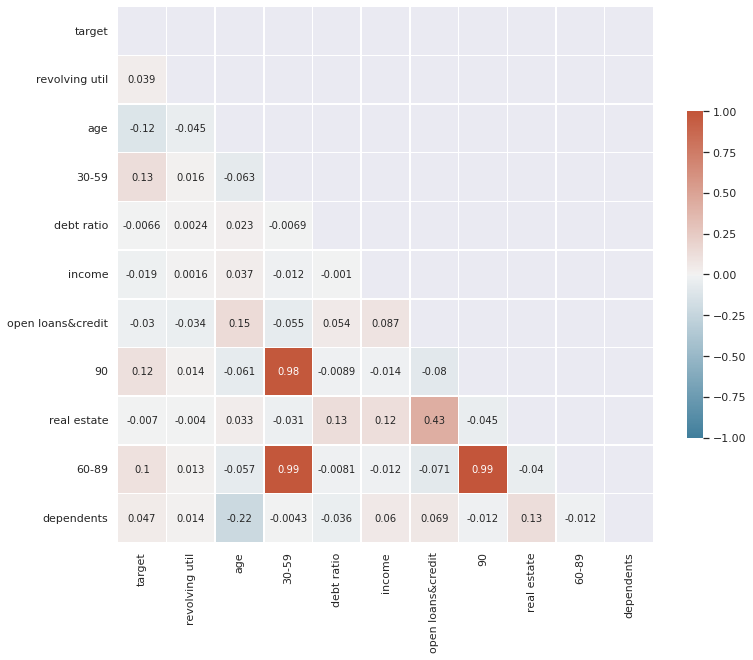

In [23]:
# Compute the correlation matrix
corr_div = data_div.corr()

# Mask for upper triangle
mask = np.triu(np.ones_like(corr_div, dtype=bool))

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(12,12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_div, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5}, annot=True)

There are strong correlation between the variables about borrowers being past due.

So, we will explore more on the correlation.

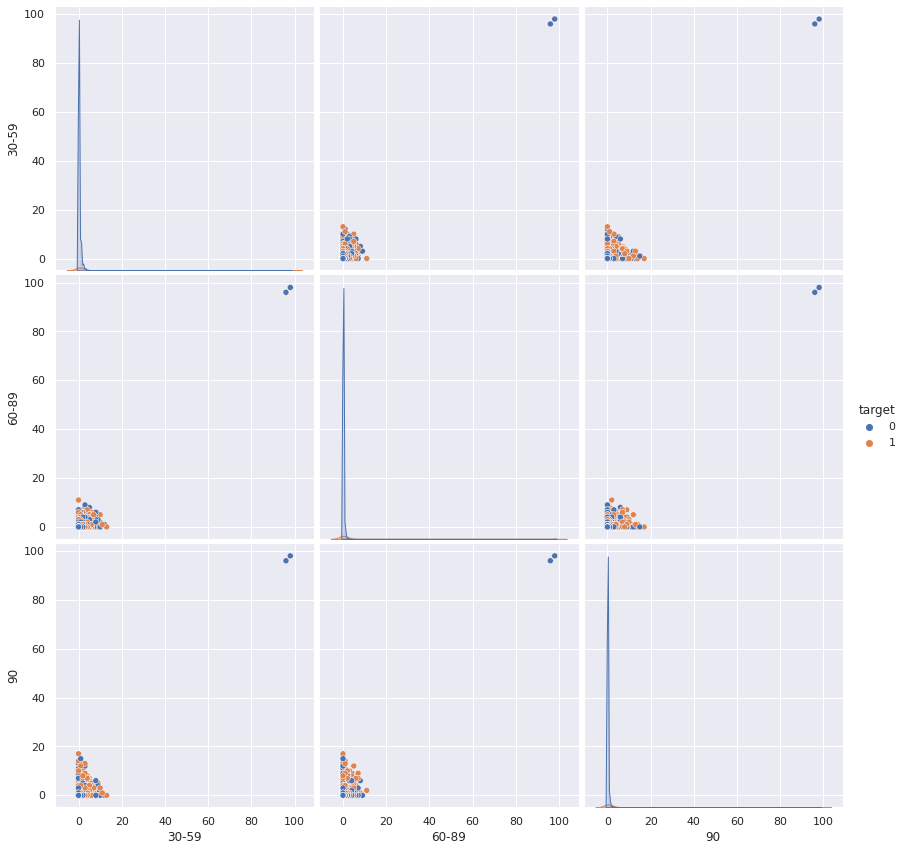

In [24]:
sns.pairplot(data_div, vars=['30-59', '60-89', '90'], hue='target',height=4)

From the pairplot, we can see that there are some outliers which skew the plot and make it harder to read.
Let's exclude this group of outliers first and try to plot it again to see the relationship in most of the data.

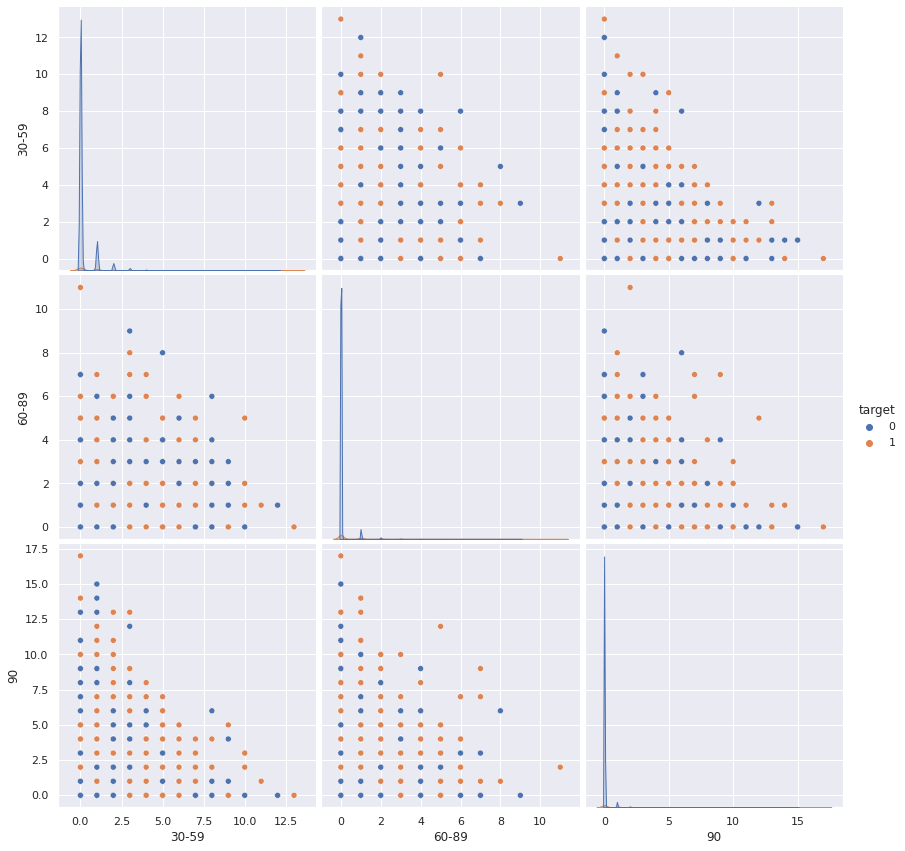

In [25]:
sns.pairplot(data_div[data_div['30-59']<50], vars=['30-59', '60-89', '90'], hue='target',height=4)

From the scatter plot, we can see that most of the people did not went past due and there is no other noticeable pattern.

After looking at the correlation matrix, we can see that there is no indication of correlation between each variables.

So, we will not use regression model and select only tree based model as shown below.

*   Decision Tree
*   Random Forest
*   CatBoost
*   XGBoost



# Train test split
***

In [29]:
col_names = data_div.columns
train, val = train_test_split(data_div,
                              test_size = 0.2)

X_train = train.drop(['target'], axis=1)
y_train = train['target']
X_val = val.drop(['target'], axis=1)
y_val = val['target']
X_test = test.drop(['target'], axis=1)
y_test = test['target']

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Before we train each model with the data, we build a function for plotting model prediction result.

In [31]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
result={}
result_down={}
result_smote={}
# Confusion Matrix
def plot_conf(pred, label):
    matrix = metrics.confusion_matrix(label, pred)
    sns.heatmap(matrix, annot=True, cmap='Blues', linewidths=0.5, fmt="d")
    
# ROC Curve
def plot_roc(res):
  for key in res.keys():
    pred = res[key][:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_val, pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = '{0} = {1:0.2f}'.format(key,roc_auc))

  plt.title('Receiver Operating Characteristic')
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')

# Model Training


## Decision Tree

In [32]:
# create Decision Tree model
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [33]:
# predict the target and probabilities
y_pred_tree = tree.predict(X_val)
y_prob_tree = tree.predict_proba(X_val)
result['Decision Tree']=y_prob_tree

print(metrics.classification_report(y_val,y_pred_tree))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94     27965
           1       0.26      0.28      0.27      2035

    accuracy                           0.90     30000
   macro avg       0.60      0.61      0.61     30000
weighted avg       0.90      0.90      0.90     30000



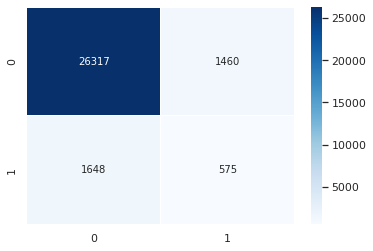

In [34]:
plot_conf(y_val,y_pred_tree)

## Random Forest

In [35]:
# create Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [36]:
# predict the target and probabilities
y_pred_rf = rf.predict(X_val)
y_prob_rf = rf.predict_proba(X_val)
result['Random Forest']=y_prob_rf

print(metrics.classification_report(y_val,y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27965
           1       0.54      0.17      0.26      2035

    accuracy                           0.93     30000
   macro avg       0.74      0.58      0.61     30000
weighted avg       0.92      0.93      0.92     30000



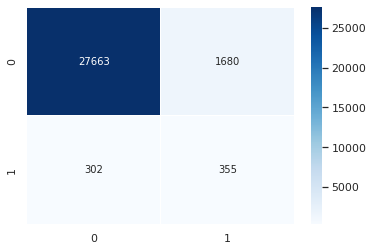

In [37]:
plot_conf(y_val,y_pred_rf)

## CatBoost

In [38]:
#set verbose = 100 to show result every 100 run
cat = CatBoostClassifier(verbose = 500)
cat.fit(X_train,y_train)

Learning rate set to 0.079569
0:	learn: 0.5872941	total: 81.9ms	remaining: 1m 21s
500:	learn: 0.1626955	total: 11.6s	remaining: 11.6s
999:	learn: 0.1534213	total: 23.4s	remaining: 0us


In [39]:
# predict the target and probabilities
y_pred_cat = cat.predict(X_val)
y_prob_cat = cat.predict_proba(X_val)
result['CatBoost'] = y_prob_cat

print(metrics.classification_report(y_val,y_pred_cat))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27965
           1       0.56      0.19      0.28      2035

    accuracy                           0.93     30000
   macro avg       0.75      0.59      0.62     30000
weighted avg       0.92      0.93      0.92     30000



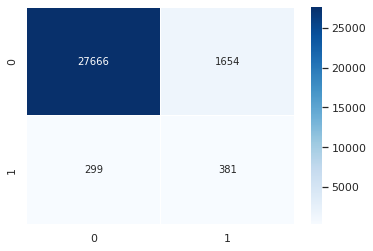

In [40]:
plot_conf(y_val,y_pred_cat)

## XGBoost

In [41]:
gb = xgb.XGBClassifier()
gb.fit(X_train, y_train)

XGBClassifier()

In [42]:
y_pred_gb = gb.predict(X_val)
y_prob_gb = gb.predict_proba(X_val)
result['XGBoost'] = y_prob_gb

print(metrics.classification_report(y_val,y_pred_gb))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27965
           1       0.61      0.18      0.28      2035

    accuracy                           0.94     30000
   macro avg       0.78      0.59      0.62     30000
weighted avg       0.92      0.94      0.92     30000



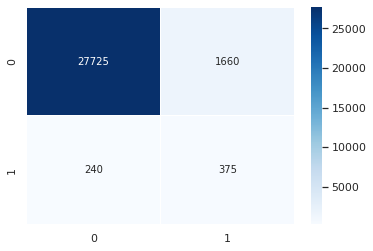

In [43]:
plot_conf(y_val,y_pred_gb)

## ROC Curve and AUC comparison

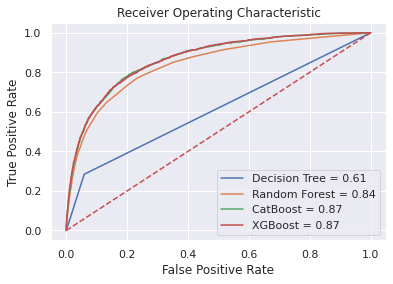

In [44]:
plot_roc(result)

The ROC curve show a pretty satisfying result but the classification matrix and confusion matrix tell a different story.

Because this dataset is imbalanced so it will generally result in a model that is biased toward the majority.

We will try to tackle this problem with sampling technique such as downsampling and SMOTE.

# Downsampling

Downsampling majority (people who doesn't delinquent) from 139974 to 50000. 

Then, the minority will be around 20% of all training data from 6%

In [45]:
train[train['target'] == 1].shape[0]/75000

0.10654666666666666

In [46]:
from sklearn.utils import resample

data_majority = train[train['target'] == 0]
data_minority = train[train['target'] == 1]
data_majority_down = resample(data_majority,
                      replace=False,
                      n_samples=75000)
data_div_down = pd.concat([data_majority_down,data_minority])

X_train_down = data_div_down.drop('target', axis=1)
y_train_down = data_div_down['target']

In [47]:
X_val = val.drop(['target'], axis=1)

scaler_down = StandardScaler()
X_train_down = scaler_down.fit_transform(X_train_down)
X_val_down = scaler_down.transform(X_val)
X_test_down = scaler_down.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


## Decision Tree

In [48]:
# create Decision Tree model
tree_down = DecisionTreeClassifier()
tree_down.fit(X_train_down, y_train_down)

DecisionTreeClassifier()

In [49]:
# predict the target and probabilities
y_pred_tree_down = tree_down.predict(X_val_down)
y_prob_tree_down = tree_down.predict_proba(X_val_down)
result_down['Decision Tree'] = y_prob_tree_down

print(metrics.classification_report(y_val,y_pred_tree_down))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93     27965
           1       0.23      0.33      0.27      2035

    accuracy                           0.88     30000
   macro avg       0.59      0.62      0.60     30000
weighted avg       0.90      0.88      0.89     30000



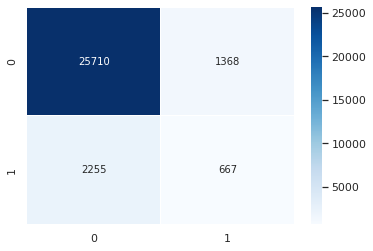

In [50]:
plot_conf(y_val,y_pred_tree_down)

## Random Forest

In [51]:
# create Decision Tree model
rf_down = RandomForestClassifier()
rf_down.fit(X_train_down, y_train_down)

RandomForestClassifier()

In [52]:
# predict the target and probabilities
y_pred_rf_down = rf_down.predict(X_val_down)
y_prob_rf_down = rf_down.predict_proba(X_val_down)
result_down['Random Forest'] = y_prob_rf_down

print(metrics.classification_report(y_val,y_pred_rf_down))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     27965
           1       0.49      0.28      0.35      2035

    accuracy                           0.93     30000
   macro avg       0.72      0.63      0.66     30000
weighted avg       0.92      0.93      0.92     30000



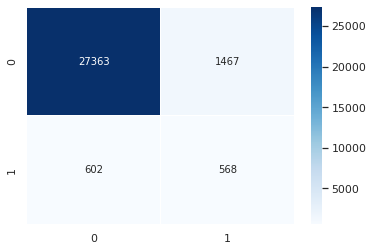

In [53]:
plot_conf(y_val,y_pred_rf_down)

## CatBoost

In [54]:
cat_down = CatBoostClassifier(verbose = 500)
cat_down.fit(X_train_down,y_train_down)

Learning rate set to 0.067977
0:	learn: 0.6072699	total: 19.4ms	remaining: 19.3s
500:	learn: 0.2081424	total: 8.44s	remaining: 8.4s
999:	learn: 0.1968617	total: 16.9s	remaining: 0us


In [55]:
# predict the target and probabilities
y_pred_down_cat = cat_down.predict(X_val_down)
y_prob_down_cat = cat_down.predict_proba(X_val_down)
result_down['CatBoost'] = y_prob_down_cat

print(metrics.classification_report(y_val,y_pred_down_cat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27965
           1       0.52      0.28      0.36      2035

    accuracy                           0.93     30000
   macro avg       0.74      0.63      0.66     30000
weighted avg       0.92      0.93      0.92     30000



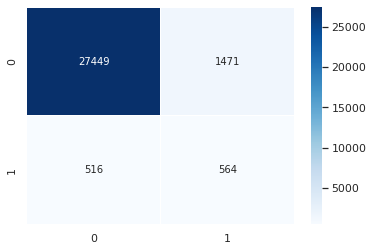

In [56]:
plot_conf(y_val,y_pred_down_cat)

## XGBoost

In [57]:
gb_down = xgb.XGBClassifier()
gb_down.fit(X_train_down,y_train_down)

XGBClassifier()

In [58]:
y_pred_gb_down = gb_down.predict(X_val_down)
y_prob_gb_down = gb_down.predict_proba(X_val_down)
result_down['XGBoost'] = y_prob_gb_down

print(metrics.classification_report(y_val,y_pred_gb_down))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27965
           1       0.54      0.27      0.36      2035

    accuracy                           0.93     30000
   macro avg       0.74      0.63      0.66     30000
weighted avg       0.92      0.93      0.92     30000



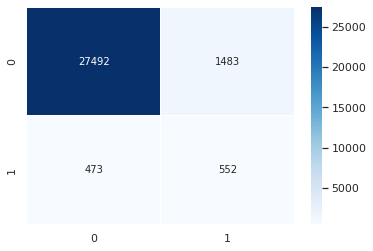

In [59]:
plot_conf(y_val,y_pred_gb_down)

## ROC Curve and AUC comparison

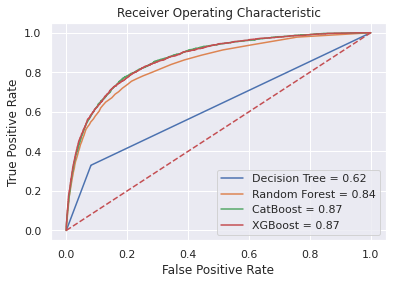

In [60]:
plot_roc(result_down)

# SMOTE

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0    112009
1     33602
Name: target, dtype: int64

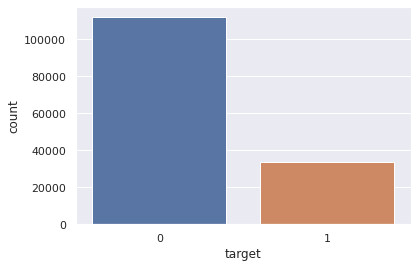

In [61]:
# transform the dataset
smote = SMOTE(sampling_strategy=0.3)
X_train_smote, y_train_smote = smote.fit_resample(train.drop("target", axis=1), train.target)

# Plot count in target column and we can see that the dataset is unbalanced
sns.countplot(y_train_smote)
y_train_smote.value_counts()

Split data for hyperparameter tuning

In [62]:
X_val = val.drop(['target'], axis=1)

scaler_smote = StandardScaler()
X_train_smote = scaler_smote.fit_transform(X_train_smote)
X_val_smote = scaler_smote.transform(X_val)
X_test_smote = scaler_smote.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [63]:
val.target.value_counts()

0    27965
1     2035
Name: target, dtype: int64

## Decision Tree

In [64]:
# create Decision Tree model
tree_smote = DecisionTreeClassifier()
tree_smote.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier()

In [65]:
# predict the target and probabilities
y_pred_smote_tree = tree_smote.predict(X_val_smote)
y_prob_smote_tree = tree_smote.predict_proba(X_val_smote)
result_smote['Decision Tree'] = y_prob_smote_tree

print(metrics.classification_report(y_val,y_pred_smote_tree))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93     27965
           1       0.20      0.34      0.25      2035

    accuracy                           0.87     30000
   macro avg       0.58      0.62      0.59     30000
weighted avg       0.90      0.87      0.88     30000



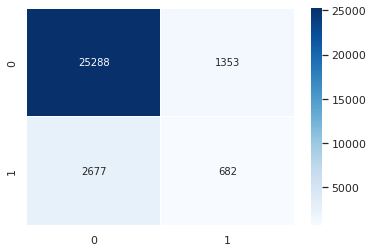

In [66]:
plot_conf(y_val,y_pred_smote_tree)

## Random Forest

In [67]:
# create Decision Tree model
rf_smote = RandomForestClassifier()
rf_smote.fit(X_train_smote, y_train_smote)

RandomForestClassifier()

In [68]:
# predict the target and probabilities
y_pred_smote_rf = rf_smote.predict(X_val_smote)
y_prob_smote_rf = rf_smote.predict_proba(X_val_smote)
result_smote['Random Forest'] = y_prob_smote_rf

print(metrics.classification_report(y_val,y_pred_smote_rf))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     27965
           1       0.40      0.32      0.36      2035

    accuracy                           0.92     30000
   macro avg       0.68      0.64      0.66     30000
weighted avg       0.91      0.92      0.92     30000



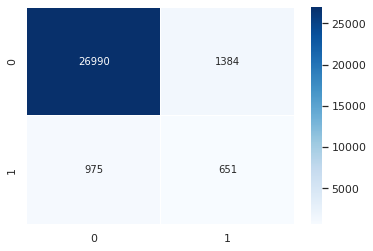

In [69]:
plot_conf(y_val,y_pred_smote_rf)

## CatBoost

In [70]:
cat_smote = CatBoostClassifier(verbose = 200)
cat_smote.fit(X_train_smote,y_train_smote)

Learning rate set to 0.086421
0:	learn: 0.6197395	total: 40.9ms	remaining: 40.9s
200:	learn: 0.2518506	total: 5.88s	remaining: 23.4s
400:	learn: 0.2404242	total: 11.6s	remaining: 17.3s
600:	learn: 0.2312031	total: 17.3s	remaining: 11.5s
800:	learn: 0.2246268	total: 23s	remaining: 5.71s
999:	learn: 0.2182696	total: 28.7s	remaining: 0us


In [71]:
# predict the target and probabilities
y_pred_smote_cat = cat_smote.predict(X_val_smote)
y_prob_smote_cat = cat_smote.predict_proba(X_val_smote)
result_smote['CatBoost'] = y_prob_smote_cat

print(metrics.classification_report(y_val,y_pred_smote_cat))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     27965
           1       0.44      0.31      0.36      2035

    accuracy                           0.93     30000
   macro avg       0.70      0.64      0.66     30000
weighted avg       0.92      0.93      0.92     30000



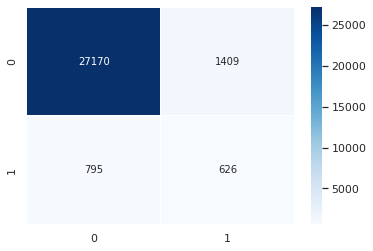

In [72]:
plot_conf(y_val,y_pred_smote_cat)

## XGBoost

In [73]:
gb_smote = xgb.XGBClassifier()
gb_smote.fit(X_train_smote,y_train_smote)

XGBClassifier()

In [74]:
y_pred_gb_smote = gb_smote.predict(X_val_smote)
y_prob_gb_smote = gb_smote.predict_proba(X_val_smote)
result_smote['XGBoost'] = y_prob_gb_smote

print(metrics.classification_report(y_val,y_pred_gb_smote))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     27965
           1       0.44      0.31      0.37      2035

    accuracy                           0.93     30000
   macro avg       0.70      0.64      0.66     30000
weighted avg       0.92      0.93      0.92     30000



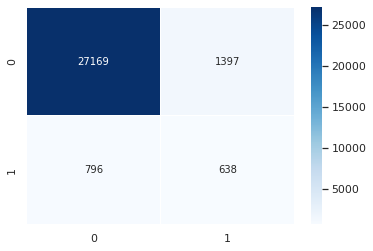

In [75]:
plot_conf(y_val,y_pred_gb_smote)

## ROC Curve and AUC comparison

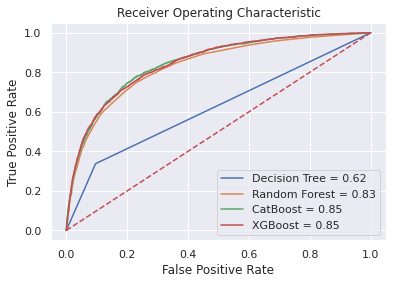

In [76]:
plot_roc(result_smote)

# Gridsearch for Selected Model


From the result on the validation set, we choose random forest and CatBoost with downsampling technique for the test set. Because this two model perform slightly better and train faster than XGBoost.

## Random Forest Downsampling


In [ ]:
# create parameter dict for GridSearchCV
param_grid = dict(
            n_estimators = [200,300],
            max_depth = [15,30],
            min_samples_split = [20,30],
            min_samples_leaf = [40,50],
            class_weight = [None,'balanced']
            )

# create Decision Tree model
rf_down = RandomForestClassifier()
rf_down = GridSearchCV(rf_down,param_grid,n_jobs = -1)
rf_down.fit(X_train_down, y_train_down)
print(rf_down.best_params_)

{'class_weight': None, 'max_depth': 15, 'min_samples_leaf': 40, 'min_samples_split': 30, 'n_estimators': 200}


In [ ]:
# predict the target and probabilities
y_pred_rf_down = rf_down.predict(X_val_down)
y_prob_rf_down = rf_down.predict_proba(X_val_down)
result_down['Random Forest'] = y_prob_rf_down

print(metrics.classification_report(y_val,y_pred_rf_down))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     28000
           1       0.52      0.27      0.36      2000

    accuracy                           0.93     30000
   macro avg       0.74      0.63      0.66     30000
weighted avg       0.92      0.93      0.93     30000



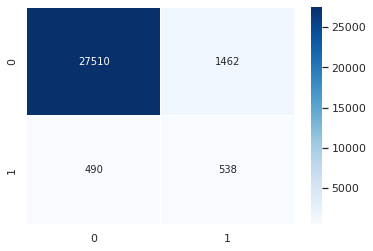

In [ ]:
plot_conf(y_val,y_pred_rf_down)

In [ ]:
# create id array for submission file
id = np.array([[i] for i in range(1,len(X_test)+1)])

In [ ]:
test_prob_rf_down = rf_down.predict_proba(X_test_down)[:,1].reshape(-1,1)
test_prob_rf_down = np.hstack([id,test_prob_rf_down])

In [ ]:
np.savetxt('rf_down.csv', test_prob_rf_down, header = 'Id,Probability' , delimiter=',', fmt=['%d','%e'], comments = '')

## CatBoost Downsampling

In [ ]:
cat_down = CatBoostClassifier(verbose=500)
param = dict(
        learning_rate=[0.05, 0.1],
        l2_leaf_reg=[10,15],
        random_strength=[0.4, 0.6],
        bagging_temperature=[0.05,0.1]
        )
cat_result = cat_down.grid_search(param, X_train_down, y_train_down)
print(cat_result)

0:	learn: 0.6801482	test: 0.6801976	best: 0.6801976 (0)	total: 36.5ms	remaining: 36.5s
500:	learn: 0.2219551	test: 0.2256005	best: 0.2256005 (500)	total: 11.8s	remaining: 11.8s
999:	learn: 0.2182805	test: 0.2244882	best: 0.2244882 (999)	total: 20.8s	remaining: 0us

bestTest = 0.224488195
bestIteration = 999

0:	loss: 0.2244882	best: 0.2244882 (0)	total: 21s	remaining: 8m 2s
0:	learn: 0.5741434	test: 0.5743632	best: 0.5743632 (0)	total: 17.5ms	remaining: 17.5s
500:	learn: 0.1995293	test: 0.2252307	best: 0.2237915 (285)	total: 9.09s	remaining: 9.05s
999:	learn: 0.1844447	test: 0.2284145	best: 0.2237915 (285)	total: 18.1s	remaining: 0us

bestTest = 0.2237914758
bestIteration = 285

1:	loss: 0.2237915	best: 0.2237915 (1)	total: 39.1s	remaining: 7m 10s
0:	learn: 0.6801483	test: 0.6801977	best: 0.6801977 (0)	total: 17.3ms	remaining: 17.3s
500:	learn: 0.2220497	test: 0.2255242	best: 0.2255242 (500)	total: 9.36s	remaining: 9.32s
999:	learn: 0.2184607	test: 0.2244343	best: 0.2244340 (995)	total

In [ ]:
# predict the target and probabilities
y_pred_down_cat = cat_down.predict(X_val_down)
y_prob_down_cat = cat_down.predict_proba(X_val_down)
result_down['CatBoost'] = y_prob_down_cat

print(metrics.classification_report(y_val,y_pred_down_cat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     28000
           1       0.49      0.29      0.37      2000

    accuracy                           0.93     30000
   macro avg       0.72      0.64      0.67     30000
weighted avg       0.92      0.93      0.92     30000



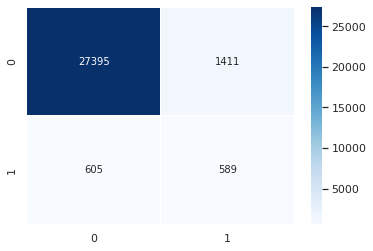

In [ ]:
plot_conf(y_val,y_pred_down_cat)

In [ ]:
test_prob_cat_down = cat_down.predict_proba(X_test_down)[:,1].reshape(-1,1)
test_prob_cat_down = np.hstack([id,test_prob_cat_down])

In [ ]:
np.savetxt('cat_down.csv', test_prob_cat_down, header = r'Id,Probability' , delimiter=',', fmt=['%d','%e'], comments = '')

## Prediction Score



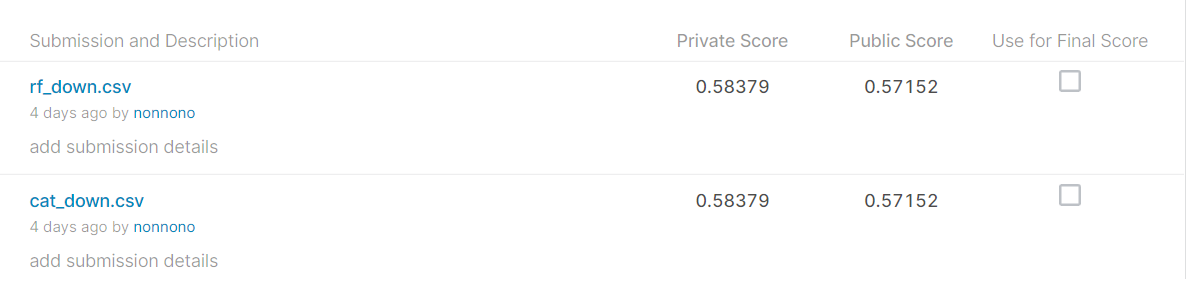

After submitting prediction of the selected model into the Kaggle competition, we found that score of the prediction surprisingly low. So, we will also try to use SMOTE technique.

## Random Forest SMOTE


In [ ]:
# create parameter dict for GridSearchCV
param_grid = dict(
            n_estimators = [300,400],
            max_depth = [30],
            min_samples_split = [20,30],
            min_samples_leaf = [40,50],
            class_weight = [None,'balanced']
            )

# create Decision Tree model
rf_smote = RandomForestClassifier()
rf_smote = GridSearchCV(rf_smote,param_grid,n_jobs = -1)
rf_smote.fit(X_train_smote, y_train_smote)
print(rf_smote.best_params_)

{'class_weight': None, 'max_depth': 30, 'min_samples_leaf': 40, 'min_samples_split': 30, 'n_estimators': 300}


In [ ]:
# predict the target and probabilities
y_pred_rf_smote = rf_smote.predict(X_val_smote)
y_prob_rf_smote = rf_smote.predict_proba(X_val_smote)
result['Random Forest'] = y_prob_rf_smote

print(metrics.classification_report(y_val,y_pred_rf_smote))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     28000
           1       0.41      0.40      0.40      2000

    accuracy                           0.92     30000
   macro avg       0.69      0.68      0.68     30000
weighted avg       0.92      0.92      0.92     30000



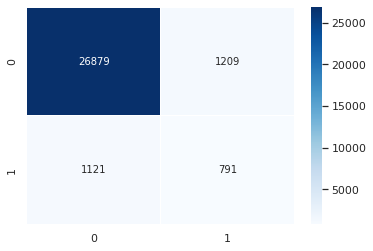

In [ ]:
plot_conf(y_val,y_pred_rf_smote)

In [ ]:
test_prob_rf_smote = rf_smote.predict_proba(X_test_smote)[:,1].reshape(-1,1)
test_prob_rf_smote = np.hstack([id,test_prob_rf_smote])

In [ ]:
np.savetxt('rf_smote.csv', test_prob_rf_smote, header = 'Id,Probability' , delimiter=',', fmt=['%d','%e'], comments = '')

## Cat SMOTE

In [ ]:
cat_smote = CatBoostClassifier(verbose=500)
param = dict(
        l2_leaf_reg=[8,10],
        random_strength=[0.2, 0.4],
        bagging_temperature=[0.1,0.2]
)
cat_result = cat_smote.grid_search(param, X_train_smote, y_train_smote)
print(cat_result)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6672953	test: 0.6673940	best: 0.6673940 (0)	total: 33.6ms	remaining: 33.5s
500:	learn: 0.2562448	test: 0.2646797	best: 0.2646797 (500)	total: 14.7s	remaining: 14.7s
999:	learn: 0.2443714	test: 0.2580774	best: 0.2580774 (999)	total: 29.2s	remaining: 0us

bestTest = 0.2580773515
bestIteration = 999

0:	loss: 0.2580774	best: 0.2580774 (0)	total: 29.4s	remaining: 3m 25s
0:	learn: 0.6672953	test: 0.6673940	best: 0.6673940 (0)	total: 29.5ms	remaining: 29.5s
500:	learn: 0.2565869	test: 0.2649236	best: 0.2649236 (500)	total: 14.6s	remaining: 14.6s
999:	learn: 0.2456511	test: 0.2585041	best: 0.2585041 (999)	total: 29s	remaining: 0us

bestTest = 0.2585041441
bestIteration = 999

1:	loss: 0.2585041	best: 0.2580774 (0)	total: 58.5s	remaining: 2m 55s
0:	learn: 0.6672443	test: 0.6673654	best: 0.6673654 (0)	total: 29.7ms	remaining: 29.7s
500:	learn: 0.2564462	test: 0.2648944	best: 0.2648944 (500)	total: 14.7s	remaining: 14.7s
999:	learn: 0.2447980	test: 0.2581892	best: 0.2581892 (999)	tot

In [ ]:
# predict the target and probabilities
y_pred_smote_cat = cat_smote.predict(X_val_smote)
y_prob_smote_cat = cat_smote.predict_proba(X_val_smote)
result_smote['CatBoost'] = y_prob_smote_cat

print(metrics.classification_report(y_val,y_pred_smote_cat))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     28000
           1       0.44      0.33      0.38      2000

    accuracy                           0.93     30000
   macro avg       0.70      0.65      0.67     30000
weighted avg       0.92      0.93      0.92     30000



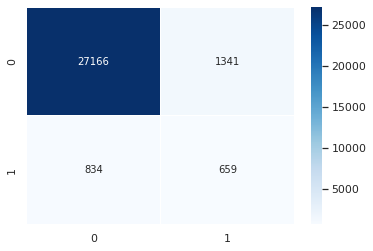

In [ ]:
plot_conf(y_val,y_pred_smote_cat)

In [ ]:
test_prob_cat_smote = cat_smote.predict_proba(X_test_smote)[:,1].reshape(-1,1)
test_prob_cat_smote = np.hstack([id,test_prob_cat_smote])
np.savetxt('cat_smote.csv', test_prob_cat_smote, header = 'Id,Probability' , delimiter=',', fmt=['%d','%e'], comments = '')

## Prediction Score

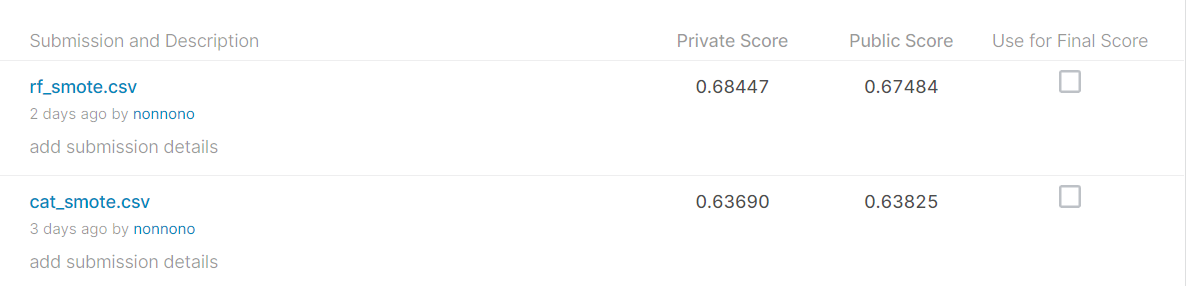

After submitting prediction of the selected model with SMOTE technique the score is still very low (compare to the leaderboard). So, we will explore the cause of this.

We found that sampling method (including downsampling and SMOTE used in this notebook) will generally help to improve the accuracy of the model but the probabilities will not represent those of the original dataset and this is where the problem lies.
 
The submission file need the class probability of each sample not the class it belong to which mean that most of the model using sampling technique will have shifted probabilities and resulting in lower score in the Kaggle submission.

So, we will try the model with out any sampling technique instead.

## Random Forest


In [30]:
# create parameter dict for GridSearchCV
param_grid = dict(
            n_estimators = [300,400],
            max_depth = [30],
            min_samples_split = [20,30],
            min_samples_leaf = [40,50],
            class_weight = [None,'balanced']
            )

# create Decision Tree model
rf = RandomForestClassifier()
rf = GridSearchCV(rf,param_grid,n_jobs = -1)
rf.fit(X_train, y_train)
print(rf.best_params_)

{'class_weight': None, 'max_depth': 30, 'min_samples_leaf': 40, 'min_samples_split': 30, 'n_estimators': 300}


In [31]:
# predict the target and probabilities
y_pred_rf = rf.predict(X_val)
y_prob_rf = rf.predict_proba(X_val)
result['Random Forest'] = y_prob_rf

print(metrics.classification_report(y_val,y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27936
           1       0.61      0.16      0.25      2064

    accuracy                           0.94     30000
   macro avg       0.77      0.58      0.61     30000
weighted avg       0.92      0.94      0.92     30000



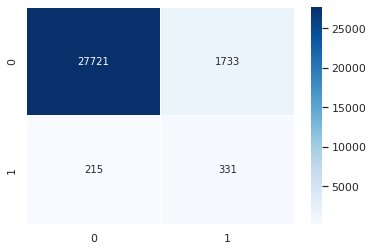

In [32]:
plot_conf(y_val,y_pred_rf)

In [ ]:
test_prob_rf = rf.predict_proba(X_test)[:,1].reshape(-1,1)
test_prob_rf = np.hstack([id,test_prob_rf])
np.savetxt('rf.csv', test_prob_rf, header = 'Id,Probability' , delimiter=',', fmt=['%d','%e'], comments = '')

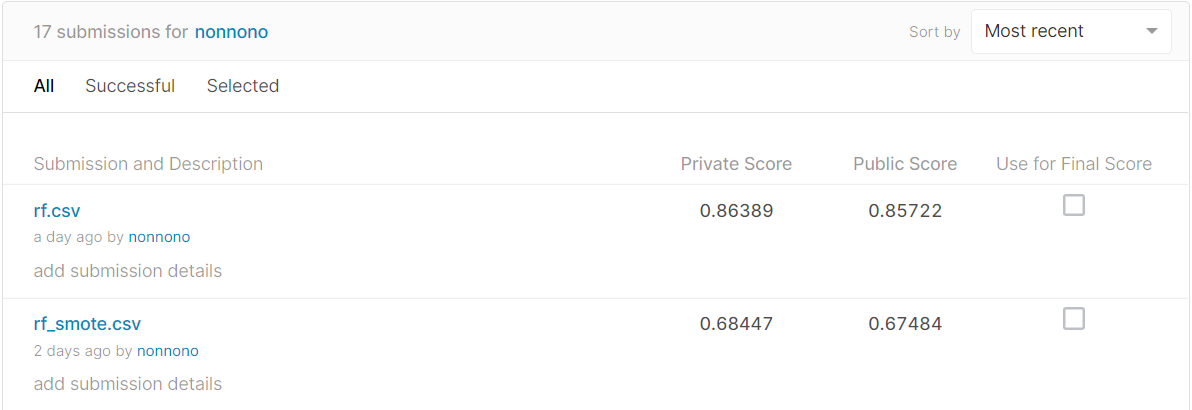

Now the accuracy is better and closer to the ones in the [Kaggle leaderboard](https://www.kaggle.com/competitions/GiveMeSomeCredit/leaderboard).

